In [1]:
import matplotlib
matplotlib.use('nbAgg')

In [2]:
%%writefile ~/.config/acq/xpdd.yml
archive_base_dir_name: .userbeamtimearchive
archive_root_dir: /nsls2/xf28id2/_xpdd
base_dir: /nsls2/xf28id2/_xpdd
beamline_host_name: [xf28id2-ws7, xf28id2-ws8]
beamline_id: 28-id-2
blconfig_dir_name: xpdConfig
blconfig_name: xpd_beamline_config.yml
calib_config_name: xpdAcq_calib_info.yml
dark_window: 3000
facility: NSLS-II
frame_acquire_time: 0.1
glbl_yaml_name: glbl.yml
group: XPD
home_dir_name: xpdUser
image_field: pe2_image
owner: XPD
simulation: True
shutter_conf: {close: 0, open: 60}
mask_kwargs:
  edge: 30
  lower_thresh: 0.0
  bs_width: 13
  tri_offset: 13
  v_asym: 0
  alpha: 3.0
dark_field_key : sc_dk_field_uid
det_image_field : pe2_image
exp_broker_name: xpdd
outbound_proxy_address: 'xf28id-ca1:5578'
inbound_proxy_address: 'xf28id-ca1:5577'
#outbound_proxy_address: 'localhost:5578'
#inbound_proxy_address: 'localhost:5577'
shutter_sleep: 0
image_fields: ['dexela_image', 'dexela']
diffraction_dets: ['dexela_image', 'dexela']
radiogram_dets: ['blackfly_det_image']
radiograph_names: ['blackfly_det_image']

Overwriting /home/mtopsakal/.config/acq/xpdd.yml


In [3]:
ls -l ~/.ipython/profile_collection/startup/

total 40
-rw-rw-rw- 1 mtopsakal mtopsakal 1296 Aug 31 22:56 00-startup.py
-rw-rw-rw- 1 mtopsakal mtopsakal 3260 Aug 31 22:56 10-motors.py
-rw-rw-rw- 1 mtopsakal mtopsakal 3688 Aug 31 22:56 15-optics.py
-rw-rw-rw- 1 mtopsakal mtopsakal 3325 Aug 31 22:56 25-cameras.py
-rw-rw-rw- 1 mtopsakal mtopsakal 3042 Aug 31 22:56 81-dexela.py
-rw-rw-rw- 1 mtopsakal mtopsakal 1464 Aug 31 22:56 82-blackfly.py
-rw-rw-rw- 1 mtopsakal mtopsakal  252 Aug 31 22:56 9991-zmq.py
-rw-rw-rw- 1 mtopsakal mtopsakal 2002 Sep  1 10:33 999-load.py
-rw-rw-rw- 1 mtopsakal mtopsakal  371 Aug 31 22:56 README
drwxrwxrwx 2 mtopsakal mtopsakal 4096 Aug 31 22:56 trash/


In [4]:
%run -i ~/.ipython/profile_collection/startup/00-startup.py
%run -i ~/.ipython/profile_collection/startup/10-motors.py
%run -i ~/.ipython/profile_collection/startup/15-optics.py
%run -i ~/.ipython/profile_collection/startup/25-cameras.py
%run -i ~/.ipython/profile_collection/startup/81-dexela.py
%run -i ~/.ipython/profile_collection/startup/82-blackfly.py

Loading metadata history from /home/mtopsakal/.config/bluesky/bluesky_history.db


/home/mtopsakal/conda_envs/collection-2019-3.0-xpdd.local/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/mtopsakal/conda_envs/collection-2019-3.0-xpdd.local/lib/python3.7/site-packages/epics/pv.py:110: UserWarning: The `context` kwarg for epics.get_pv() is deprecated. New PVs will _not_ be created in the requested context.
  'The `context` kwarg for epics.get_pv() is deprecated. New PVs '


In [5]:

import os
from xpdacq.xpdacq_conf import (glbl_dict, configure_device,
                                _reload_glbl, _set_glbl,
                                _load_beamline_config)

# configure experiment device being used in current version
if glbl_dict['is_simulation']:
    from xpdacq.simulation import (xpd_pe1c, db, cs700, shctl1,
                                   ring_current, fb)
    pe1c = xpd_pe1c # alias

configure_device(area_det=dexela, shutter=shctl1,
                 temp_controller=cs700, db=db,
                 filter_bank=fb,
                 ring_current=ring_current,
                 )

# cache previous glbl state
reload_glbl_dict = _reload_glbl()
from xpdacq.glbl import glbl

# reload beamtime
from xpdacq.beamtimeSetup import (start_xpdacq, _start_beamtime,
                                  _end_beamtime)

bt = start_xpdacq()
if bt is not None:
    print("INFO: Reload beamtime objects:\n{}\n".format(bt))
if reload_glbl_dict is not None:
    _set_glbl(glbl, reload_glbl_dict)

# import necessary modules
from xpdacq.xpdacq import *
from xpdacq.beamtime import *
from xpdacq.utils import import_sample_info

# instantiate xrun without beamtime, like bluesky setup
xrun = CustomizedRunEngine(None)
xrun.md['beamline_id'] = glbl['beamline_id']
xrun.md['group'] = glbl['group']
xrun.md['facility'] = glbl['facility']
beamline_config = _load_beamline_config(glbl['blconfig_path'])
xrun.md['beamline_config'] = beamline_config

# insert header to db, either simulated or real
xrun.subscribe(db.insert, 'all')

if bt:
    xrun.beamtime = bt

HOME_DIR = glbl['home']
BASE_DIR = glbl['base']

print('INFO: Initializing the XPD data acquisition environment\n')
if os.path.isdir(HOME_DIR):
    os.chdir(HOME_DIR)
else:
    os.chdir(BASE_DIR)

from xpdacq.calib import *

# analysis functions, only at beamline
#from xpdan.data_reduction import *

print('OK, ready to go.  To continue, follow the steps in the xpdAcq')
print('documentation at http://xpdacq.github.io/xpdacq\n')



/home/mtopsakal/conda_envs/collection-2019-3.0-xpdd.local/lib/python3.7/site-packages/xpdconf/conf.py:38: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  d = yaml.load(f)
/home/mtopsakal/conda_envs/collection-2019-3.0-xpdd.local/lib/python3.7/site-packages/ophyd/sim.py:671: UserWarning: The parameter 'reg' is deprecated. It will be ignored. In a future release the parameter will be removed and passing a value for 'reg' will raise an error.
  warnings.warn("The parameter 'reg' is deprecated. It will be "
/home/mtopsakal/conda_envs/collection-2019-3.0-xpdd.local/lib/python3.7/site-packages/xpdacq/xpdacq_conf.py:130: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  reload_dict = yaml.load(f)
/home/mtopsakal/conda_envs/collection-2019-3.0-xpdd.local/lib/python3.7

INFO: Reload beamtime objects:

ScanPlans:
0: ct_5
1: ct_0.1
2: ct_1
3: ct_10
4: ct_30
5: ct_60

Samples:
0: Setup
1: LaB6
2: CeO2
3: Kapton



/home/mtopsakal/conda_envs/collection-2019-3.0-xpdd.local/lib/python3.7/site-packages/xpdacq/xpdacq_conf.py:100: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  beamline_config = yaml.load(f)


INFO: area detector has been configured to new acquisition time (time per frame)  = 0.1s
{'Verification time': '2019-09-01 10:34:26',
 'Verified by': 'mt',
 'hello': 'world'}



Is this configuration correct? y/n:  y
Please input your initials:  mt


INFO: beamtime object has been linked

INFO: Initializing the XPD data acquisition environment

OK, ready to go.  To continue, follow the steps in the xpdAcq
documentation at http://xpdacq.github.io/xpdacq



In [6]:
glbl['inbound_proxy_address']

'xf28id-ca1:5577'

In [7]:
%run -i ~/.ipython/profile_collection/startup/9991-zmq.py

In [8]:
from bluesky.utils import install_nb_kicker

In [9]:
PI_name = 'Lynne Ecker'
saf_num = 304490
wavelength = 0.18088
experimenters = [('Topsakal', 'Mehmet', 1),
                 ('Sprouster ', 'David', 2)]

#bt = _start_beamtime(PI_name, saf_num, experimenters, wavelength=wavelength)
xrun.beamtime = bt

INFO: beamtime object has been linked



In [10]:
bt

{'bt_piLast': 'Lynne_Ecker',
 'bt_safN': '304490',
 'bt_experimenters': [('Topsakal', 'Mehmet', 1), ('Sprouster ', 'David', 2)],
 'bt_wavelength': 0.18088,
 'bt_uid': '168774da'}

In [11]:
import_sample_info(saf_num, bt)

INFO: using SAF_number = 304490
INFO: If you want to associate a background sample, e.g., empty kapton tube, with samples,
place the sample-name of the background sample in the column ['sample-name_of_sample_background']
of the sample excel spreadsheet.
The following samples do not have background_samples associated with them
(typically background samples won't have associated background samples):
['Setup', 'LaB6', 'CeO2', 'Kapton']

*** End of import Sample object ***


In [12]:
bt.list()


ScanPlans:
0: ct_5
1: ct_0.1
2: ct_1
3: ct_10
4: ct_30
5: ct_60

Samples:
0: Setup
1: LaB6
2: CeO2
3: Kapton


In [14]:
# doesn't work
# RE(bp.count([blackfly]))

In [15]:
RE(bp.count([dexela]))

Transient Scan ID: 49     Time: 2019-09-03 08:41:59
Persistent Unique Scan ID: '54f25263-3945-4d80-8fd2-7acd68e2a00e'

dexela [Complete.]                                                             
                                                                               
New stream: 'primary'
+-----------+------------+
|   seq_num |       time |
+-----------+------------+
|         1 | 08:42:00.1 |
+-----------+------------+
generator count ['54f25263'] (scan num: 49)





('54f25263-3945-4d80-8fd2-7acd68e2a00e',)

In [17]:
xrun(1,0)

INFO: requested exposure time = 5 - > computed exposure time= 0.1
INFO: No calibration file found in config_base.
Scan will still keep going on....
INFO: Current filter status
INFO: flt1 : In
INFO: flt2 : Out
INFO: flt3 : Out
INFO: flt4 : Out
+-----------+------------+
|   seq_num |       time |
+-----------+------------+
|         1 | 08:44:10.1 |
+-----------+------------+
generator count ['16ed28c3'] (scan num: 2)


('16ed28c3-fce6-45ae-ac85-a618d4703e12',)

In [25]:
xrun(1,0)

INFO: requested exposure time = 5 - > computed exposure time= 0.1
INFO: No calibration file found in config_base.
Scan will still keep going on....
INFO: Current filter status
INFO: flt1 : In
INFO: flt2 : Out
INFO: flt3 : Out
INFO: flt4 : Out
+-----------+------------+
|   seq_num |       time |
+-----------+------------+
|         1 | 23:50:33.6 |
+-----------+------------+
generator count ['d3796c91'] (scan num: 4)


('d3796c91-33a6-454a-84d4-392af08b6fa8',)

In [18]:
import os

# motors
f=os.popen(" cat ~/.ipython//profile_collection/startup/10-motors.py | grep EpicsMotor | awk '{print $1}' ")
motors = [i.split()[0] for i in f.readlines()]
for i in motors:
    try:
        print([i,globals()[i].report])
    except:
        pass
    
# optics
f=os.popen(" cat ~/ipython/profile_collection/startup/15-optics.py | grep EpicsMotor | awk '{print $1}' ")
motors = [i.split()[0] for i in f.readlines()]
for i in motors:
    try:
        print([i,globals()[i].report])
    except:
        pass
    

['th_cal', {'position': -36.91365624999999, 'pv': 'XF:28IDC-ES:1{Dif:2-Ax:Th}Mtr.RBV'}]
['tth_cal', {'position': 0.0, 'pv': 'XF:28IDC-ES:1{Dif:2-Ax:2Th}Mtr.RBV'}]
['ecal_x', {'position': 41.00000000000002, 'pv': 'XF:28IDC-ES:1{Dif:2-Ax:X}Mtr.RBV'}]
['ecal_y', {'position': -34.0, 'pv': 'XF:28IDC-ES:1{Dif:2-Ax:Y}Mtr.RBV'}]
['ss_stg2_x', {'position': 0.75, 'pv': 'XF:28IDC-ES:1{Stg:Smpl2-Ax:X}Mtr.RBV'}]
['ss_stg2_y', {'position': 12.8, 'pv': 'XF:28IDC-ES:1{Stg:Smpl2-Ax:Y}Mtr.RBV'}]
['ss_stg2_z', {'position': 18.0, 'pv': 'XF:28IDC-ES:1{Stg:Smpl2-Ax:Z}Mtr.RBV'}]
['th', {'position': 140.0808410014, 'pv': 'XF:28IDC-ES:1{Dif:1-Ax:Th}Mtr.RBV'}]
['tth', {'position': -34.999887796299994, 'pv': 'XF:28IDC-ES:1{Dif:1-Ax:2ThI}Mtr.RBV'}]
['diff_x', {'position': 49.25, 'pv': 'XF:28IDC-ES:1{Dif:1-Ax:X}Mtr.RBV'}]
['diff_y', {'position': 10.25, 'pv': 'XF:28IDC-ES:1{Dif:1-Ax:Y}Mtr.RBV'}]
['diff_tth_i', {'position': -34.999887796299994, 'pv': 'XF:28IDC-ES:1{Dif:1-Ax:2ThI}Mtr.RBV'}]
['diff_tth_o', {'position'

In [19]:
phi.move(0)

MoveStatus(done=True, pos=phi, elapsed=0.0, success=True, settle_time=0.0)

In [20]:
from pprint import pprint

# scan a motor from 1 to 5, taking 5 equally-spaced readings of 'det'
# RE(bp.scan([dexela], phi, 1, 5, 5))

# scan a motor from 1 to 5 *relative to its current position*
# RE(bp.rel_scan([dexela], phi, -2, 2, 5))

# scan a motor through a list of user-specified positions
# RE(bp.list_scan([dexela], phi, [1, 1, 2, 3, 0]))

{'path': <matplotlib.lines.Line2D at 0x7fdf84179c88>,
 'events': <matplotlib.collections.PatchCollection at 0x7fdf84179cc0>}

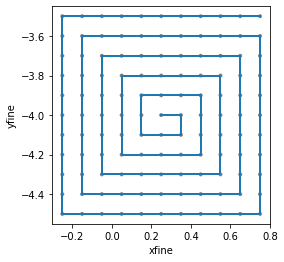

In [21]:
%matplotlib inline

from bluesky.simulators import plot_raster_path


xy_plan = bp.spiral_square([dexela], xfine, yfine, x_center=0.25, y_center=-4.0,
                     x_range=1.0, y_range=1.0, x_num=11, y_num=11)
plot_raster_path(xy_plan, 'xfine', 'yfine', probe_size=.01)

In [42]:
xy_plan = bp.spiral_square([dexela], xfine, yfine, x_center=0.25, y_center=-4.0,
                     x_range=1.0, y_range=1.0, x_num=11, y_num=11)

xrun(1, xy_plan, LiveTable([xfine,yfine]))

INFO: No calibration file found in config_base.
Scan will still keep going on....
INFO: Current filter status
INFO: flt1 : In
INFO: flt2 : Out
INFO: flt3 : Out
INFO: flt4 : Out
+-----------+------------+------------+---------------------+------------+---------------------+
|   seq_num |       time |      xfine | xfine_user_setpoint |      yfine | yfine_user_setpoint |
+-----------+------------+------------+---------------------+------------+---------------------+
|         1 | 00:20:03.4 |     0.2500 |              0.2500 |    -4.0000 |             -4.0000 |
|         2 | 00:20:04.9 |     0.3500 |              0.3500 |    -4.0000 |             -4.0000 |
|         3 | 00:20:07.0 |     0.3500 |              0.3500 |    -4.1000 |             -4.1000 |
|         4 | 00:20:08.4 |     0.2500 |              0.2500 |    -4.1000 |             -4.1000 |
|         5 | 00:20:10.1 |     0.1500 |              0.1500 |    -4.1000 |             -4.1000 |
|         6 | 00:20:12.2 |     0.1500 |        

('eb45c9e0-64d9-4a13-81b8-bcba911154ea',)

In [44]:
xfine.move(0.25)
yfine.move(-4)

MoveStatus(done=True, pos=yfine, elapsed=5.2, success=True, settle_time=0.0)

In [22]:
xrun(0,0)

INFO: requested exposure time = 5 - > computed exposure time= 0.1
INFO: No calibration file found in config_base.
Scan will still keep going on....
INFO: Current filter status
INFO: flt1 : In
INFO: flt2 : Out
INFO: flt3 : Out
INFO: flt4 : Out
+-----------+------------+
|   seq_num |       time |
+-----------+------------+
|         1 | 08:45:28.2 |
+-----------+------------+
generator count ['772b62f3'] (scan num: 3)


('772b62f3-d184-41b0-8a25-d435556e0005',)

In [24]:
xrun(1,1)

INFO: requested exposure time = 0.1 - > computed exposure time= 0.1
INFO: No calibration file found in config_base.
Scan will still keep going on....
INFO: Current filter status
INFO: flt1 : In
INFO: flt2 : Out
INFO: flt3 : Out
INFO: flt4 : Out
+-----------+------------+
|   seq_num |       time |
+-----------+------------+
|         1 | 08:47:29.1 |
+-----------+------------+
generator count ['e7525cd3'] (scan num: 5)


('e7525cd3-fb56-4072-ba35-6aad29b1438c',)